[AGENT] Loaded 9313 articles from articles\AAPL.csv
[AGENT] Sentiment analysis completed.
[AGENT] Daily summary generated.
[AGENT] Memory saved to sentiment_scores\AAPL_memory.csv
[AGENT] AAPL: 9313 articles, 634 daily rows


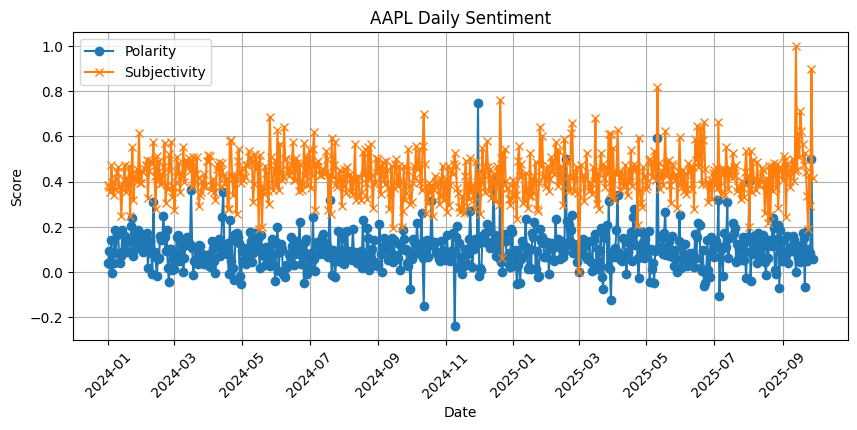

In [2]:
# ─── SINGLE-CELL LOCAL AGENTIC AI FOR ARTICLES ───────────────────────────────
import os
from pathlib import Path
import pandas as pd
from textblob import TextBlob
from datetime import datetime
import matplotlib.pyplot as plt

ART_DIR = Path("articles")        # folder with article CSVs per ticker
OUT_DIR = Path("sentiment_scores")
OUT_DIR.mkdir(exist_ok=True)

class LocalAgenticNewsAI:
    def __init__(self, news_csv_path=None):
        self.memory = pd.DataFrame(columns=['date', 'title', 'content', 'polarity', 'subjectivity'])
        if news_csv_path and os.path.exists(news_csv_path):
            self.load_articles(news_csv_path)

    def load_articles(self, path):
        df = pd.read_csv(path)
        if 'publishedDate' in df.columns:
            df['date'] = pd.to_datetime(df['publishedDate']).dt.date
        else:
            df['date'] = datetime.now().date()
        df['polarity'] = None
        df['subjectivity'] = None
        df = df.rename(columns={'title':'title', 'content':'content'})
        self.memory = df[['date','title','content','polarity','subjectivity']]
        print(f"[AGENT] Loaded {len(self.memory)} articles from {path}")

    def add_article(self, title, content, date=None):
        date = date or datetime.now().date()
        new_article = pd.DataFrame([{
            'date': date, 'title': title, 'content': content,
            'polarity': None, 'subjectivity': None
        }])
        self.memory = pd.concat([self.memory, new_article], ignore_index=True)

    def analyze_sentiment(self):
        if self.memory.empty: return
        self.memory['polarity'] = self.memory['content'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
        self.memory['subjectivity'] = self.memory['content'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
        print("[AGENT] Sentiment analysis completed.")

    def summarize_daily(self):
        if self.memory.empty: return pd.DataFrame()
        summary = self.memory.groupby('date').agg({
            'polarity': 'mean',
            'subjectivity': 'mean',
            'title': 'count'
        }).rename(columns={'title': 'num_articles'}).reset_index()
        print("[AGENT] Daily summary generated.")
        return summary

    def save_memory(self, path):
        self.memory.to_csv(path, index=False)
        print(f"[AGENT] Memory saved to {path}")

    def run(self, save_path=None):
        self.analyze_sentiment()
        summary = self.summarize_daily()
        save_path = save_path or "agent_memory.csv"
        self.save_memory(save_path)
        return summary

# ─── PROCESS TICKERS ───────────────────────────────────────────────────────
tickers_input = input("Enter ticker symbols (comma-separated, e.g. AAPL,MSFT): ")
TICKERS = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]
results = {}

for ticker in TICKERS:
    csv_path = ART_DIR / f"{ticker}.csv"
    agent = LocalAgenticNewsAI(csv_path if csv_path.exists() else None)
    daily_summary = agent.run(save_path=OUT_DIR/f"{ticker}_memory.csv")
    results[ticker] = {"articles": agent.memory, "daily": daily_summary}
    print(f"[AGENT] {ticker}: {len(agent.memory)} articles, {len(daily_summary)} daily rows")

# ─── PLOT DAILY SENTIMENT ──────────────────────────────────────────────────
for ticker, data in results.items():
    daily_df = data["daily"]
    if daily_df.empty: continue
    plt.figure(figsize=(10,4))
    plt.plot(daily_df["date"], daily_df["polarity"], marker='o', label="Polarity")
    plt.plot(daily_df["date"], daily_df["subjectivity"], marker='x', label="Subjectivity")
    plt.title(f"{ticker} Daily Sentiment")
    plt.xlabel("Date")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()


